In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import glob
import os
import cv2
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda import amp
from tqdm import tqdm
import time
import copy
from collections import defaultdict
import gc
from glob import glob
import re
from tensorflow.keras.utils import Sequence
import random
import plotly.express as px
#from plotly.offline import init_notebook_mode

#init_notebook_mode(connected=True)

#data loads


In [3]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 18.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=5a47d6874bf067c9a0e9c2a9a4d41f8caab2f451ce73513ee827476484a4e5c2
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=f54784f357784d9be5fbe33861df0093b0080cda410b049a4e957fda7689acd8
  Stored in directory: /root/.cache/pip/w

In [4]:
!unzip "/content/drive/MyDrive/GI_TRACK1/train.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/case78/case78_day0/scans/slice_0055_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0056_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0057_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0058_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0059_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0060_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0061_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0062_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0063_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0064_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0065_360_310_1.50_1.50.png  
  inflating: train/case78/case78_day0/scans/slice_0066_360_310_1.50_1.50.png  
 

In [5]:
!unzip "/content/drive/MyDrive/GI_TRACK1/train.csv.zip"

Archive:  /content/drive/MyDrive/GI_TRACK1/train.csv.zip
  inflating: train.csv               


#data prep

In [6]:
data = pd.read_csv(r"train.csv")

In [7]:

data.head(3)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN


In [8]:
data.shape

(115488, 3)

In [9]:
data.nunique()

id              38496
class               3
segmentation    33899
dtype: int64

In [10]:
df1 = data.pivot_table(values='segmentation',index='id',columns='class',aggfunc='max').reset_index()

In [11]:
df1.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


In [12]:
df1.shape

(16590, 4)

In [13]:
df2 = data.drop_duplicates(subset=['id'])

In [14]:
df2.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
3,case123_day20_slice_0002,large_bowel,NaN
6,case123_day20_slice_0003,large_bowel,NaN
9,case123_day20_slice_0004,large_bowel,NaN
12,case123_day20_slice_0005,large_bowel,NaN


In [15]:
df3 = pd.DataFrame(columns=['id','large_bowel','small_bowel','stomach'])
df3['id'] = df2[~df2['id'].isin(df1['id'])].id.values

In [16]:
df3.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,NaN,NaN,NaN
1,case123_day20_slice_0002,NaN,NaN,NaN
2,case123_day20_slice_0003,NaN,NaN,NaN
3,case123_day20_slice_0004,NaN,NaN,NaN
4,case123_day20_slice_0005,NaN,NaN,NaN


In [17]:
data = pd.concat([df1,df3])
data.reset_index(inplace=True,drop=True)
data.head(10)

,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...
5,case101_day20_slice_0071,NaN,NaN,28117 12 28382 16 28647 18 28912 21 29177 24 2...
6,case101_day20_slice_0072,NaN,NaN,27053 9 27317 14 27582 16 27847 19 28112 22 28...
7,case101_day20_slice_0073,NaN,NaN,26786 9 27050 14 27314 18 27579 21 27844 23 28...
8,case101_day20_slice_0074,31080 6 31345 8 31610 10 31876 10 32142 10 324...,NaN,26517 10 26781 16 27046 19 27311 22 27577 23 2...
9,case101_day20_slice_0075,30813 7 31078 10 31343 11 31609 12 31875 12 32...,NaN,25984 12 26249 15 26514 18 26779 20 27044 23 2...


In [18]:
data.shape

(38496, 4)

In [19]:
data['case'] = data['id'].apply(lambda x: re.findall("\d+",x)[0])
data['day'] = data['id'].apply(lambda x: re.findall("\d+",x)[1])
data['slice'] = data['id'].apply(lambda x: re.findall("\d+",x)[2])

In [20]:
data

,id,large_bowel,small_bowel,stomach,case,day,slice
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...,101,20,0066
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...,101,20,0067
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,101,20,0068
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...,101,20,0069
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...,101,20,0070
...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,NaN,NaN,NaN,30,0,0140
38492,case30_day0_slice_0141,NaN,NaN,NaN,30,0,0141
38493,case30_day0_slice_0142,NaN,NaN,NaN,30,0,0142
38494,case30_day0_slice_0143,NaN,NaN,NaN,30,0,0143


In [21]:
path_df = pd.DataFrame(data=glob("/content/train/*/*/*/*"),columns=['image_paths'])

In [22]:
path_df.head()

,image_paths
0,/content/train/case123/case123_day20/scans/sli...
1,/content/train/case123/case123_day20/scans/sli...
2,/content/train/case123/case123_day20/scans/sli...
3,/content/train/case123/case123_day20/scans/sli...
4,/content/train/case123/case123_day20/scans/sli...


In [23]:
path_df['case'] = path_df['image_paths'].apply(lambda x: re.findall("\d+",x)[1])
path_df['day'] = path_df['image_paths'].apply(lambda x: re.findall("\d+",x)[2])
path_df['slice'] = path_df['image_paths'].apply(lambda x: re.findall("\d+",x)[3])
path_df['width'] = path_df['image_paths'].apply(lambda x: re.findall("\d+",x)[4])
path_df['height'] = path_df['image_paths'].apply(lambda x: re.findall("\d+",x)[5])
#path_df['pixel_x'] = path_df['image_paths'].apply(lambda x: re.findall("\d+\.\d+",x)[0])
#path_df['pixel_y'] = path_df['image_paths'].apply(lambda x: re.findall("\d+\.\d+",x)[1])

In [24]:
path_df.head()

,image_paths,case,day,slice,width,height
0,/content/train/case123/case123_day20/scans/sli...,123,20,0033,266,266
1,/content/train/case123/case123_day20/scans/sli...,123,20,0091,266,266
2,/content/train/case123/case123_day20/scans/sli...,123,20,0049,266,266
3,/content/train/case123/case123_day20/scans/sli...,123,20,0096,266,266
4,/content/train/case123/case123_day20/scans/sli...,123,20,0041,266,266


In [25]:
data = data.merge(path_df, how='left', on=['case','day','slice'])

In [26]:
data.sort_values(by=['case','day','slice'],ignore_index=True, inplace=True)
data.head(10)

,id,large_bowel,small_bowel,stomach,case,day,slice,image_paths,width,height
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,/content/train/case101/case101_day20/scans/sli...,266,266
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,/content/train/case101/case101_day20/scans/sli...,266,266
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,/content/train/case101/case101_day20/scans/sli...,266,266
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,/content/train/case101/case101_day20/scans/sli...,266,266
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,/content/train/case101/case101_day20/scans/sli...,266,266
5,case101_day20_slice_0006,NaN,NaN,NaN,101,20,0006,/content/train/case101/case101_day20/scans/sli...,266,266
6,case101_day20_slice_0007,NaN,NaN,NaN,101,20,0007,/content/train/case101/case101_day20/scans/sli...,266,266
7,case101_day20_slice_0008,NaN,NaN,NaN,101,20,0008,/content/train/case101/case101_day20/scans/sli...,266,266
8,case101_day20_slice_0009,NaN,NaN,NaN,101,20,0009,/content/train/case101/case101_day20/scans/sli...,266,266
9,case101_day20_slice_0010,NaN,NaN,NaN,101,20,0010,/content/train/case101/case101_day20/scans/sli...,266,266


In [27]:
data['width'] = data['width'].astype(int)
data['height'] = data['height'].astype(int)



In [28]:
def mask_from_rle(rle, shape):
    
    if type(rle) == float: # if nan
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

    segm = np.asarray(rle.split(), dtype=int)
    start_point = segm[0::2] - 1
    length_point = segm[1::2]
    end_point = start_point + length_point
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 255

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [29]:
def RGBMask(record):
    
    shape = (record['height'], record['width'], 3)
    mask = np.zeros(shape, dtype=np.uint8)
    
    small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
    large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
    stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))
    
    mask[...,0] = large
    mask[...,1] = small
    mask[...,2] = stomach
    
    return mask

In [30]:
#generatings masks and saving them
mask_paths = []
for i in range(len(data)):
  r = data.iloc[i]
  k =  RGBMask(r)
  name = r["image_paths"]
  name = name.replace("train","masks")
  v = name.rfind("/")
  base = name[:v]
  if os.path.isdir(base):
    f = f"{base}/{name[v+1:]}"
    cv2.imwrite(f,k)
    mask_paths.append(f) 
    #plt.savefig(f)
  else:
    os.makedirs(base)
    f = f"{base}/{name[v+1:]}"
    cv2.imwrite(f,k)
    mask_paths.append(f) 
  


In [31]:
data["mask_paths"] = mask_paths

In [32]:
data.head()

,id,large_bowel,small_bowel,stomach,case,day,slice,image_paths,width,height,mask_paths
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...


In [33]:
data.dtypes

id             object
large_bowel    object
small_bowel    object
stomach        object
case           object
day            object
slice          object
image_paths    object
width           int64
height          int64
mask_paths     object
dtype: object

In [34]:
data["stomach"][0],data["large_bowel"][0],data["small_bowel"][0]

(nan, nan, nan)

In [35]:
type(data["stomach"][0])

float

In [36]:
empty = []
for i in range(len(data)):
  if type(data["large_bowel"][i]) == float and type(data["small_bowel"][i]) == float and type(data["stomach"][i]) == float:
    empty.append(True)
  else:
    empty.append(False)

In [37]:
data["empty"] = empty

In [38]:
data.head()

,id,large_bowel,small_bowel,stomach,case,day,slice,image_paths,width,height,mask_paths,empty
0,case101_day20_slice_0001,NaN,NaN,NaN,101,20,0001,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...,True
1,case101_day20_slice_0002,NaN,NaN,NaN,101,20,0002,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...,True
2,case101_day20_slice_0003,NaN,NaN,NaN,101,20,0003,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...,True
3,case101_day20_slice_0004,NaN,NaN,NaN,101,20,0004,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...,True
4,case101_day20_slice_0005,NaN,NaN,NaN,101,20,0005,/content/train/case101/case101_day20/scans/sli...,266,266,/content/masks/case101/case101_day20/scans/sli...,True


In [39]:
df = data.copy()

#code

In [40]:
#Ploting functions
def show_images(image, mask=None):
    image = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    image = image.astype('float32')
    #image = cv2.merge((image, image))
    plt.figure(figsize =  (40, 40))
    plt.imshow(image, cmap = 'bone')
    
    if mask is not None:
        mask = cv2.imread(mask,0)
        #plt.figure(figsize = (60,60))
        plt.imshow(mask, cmap = 'gray', alpha=0.5)


def subplot(df):
    plt.figure(figsize = (60,60))
    for i, j in enumerate(range(66,90)):
        img = df.image_paths.iloc[j]
        mask = df.mask_path.iloc[j]
        plt.subplot(8,4,i+1)
        i += 1
        show_images(img, mask)

In [41]:
#More than 8 bit pngs are not supported currently in 
#torchvision.io.read_image#
size = np.array([256, 256])
def load_image(path):
    #img = np.load(path)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.merge((img, img, img))
    img = img.astype('float32') # original is uint16
    #clahe = cv2.createCLAHE(clipLimit = 5)
    #img = clahe.apply(img) + 30
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
    img = img / np.max(img)
    
    #img_shape = np.array(img.shape)
    #d = size - img_shape
    #if np.any(size != img_shape):
        #p0 = d[0]
        #p1 = d[1]
        #py = [p0//2, p0//2 + p0%2]
        #px = [p1//2, p1//2 + p1%2]
        #img = np.pad(img, [py, px])
        #img = img.reshape((*size))
        #mx = np.max(img)
        #if mx:
            #img/=mx # scale image to [0, 1]
        #return img
    return img


In [42]:
def load_mask(path):
    #msk = np.load(path)
    mask = cv2.imread(path, 1)
    mask = mask.astype('float32') #eta na korle vvi step ta kora jabena
    mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_AREA)
    mask /= 255.0
    
    #mask_shape = np.array(mask.shape)
    #d = size - mask_shape
    #if np.any(size != mask_shape):
        #p0 = d[0]
        #p1 = d[1]
        #py = [p0//2, p0//2 + p0%2]
        #px = [p1//2, p1//2 + p1%2]
        #mask = np.pad(mask, [py, px])
        #mask = mask.reshape((*size))
        #mx = np.max(mask)
        #mask/=255.0 #VVI Step..eta na korle loss function r value negative hoye jabe
        #return mask
    return  mask

In [43]:
#Define the Dataset
img_size = [256, 256]


class dataset(torch.utils.data.Dataset):
    
    def __init__(self, X, labels = True, transform = None):
        self.X = X
        self.labels = labels
        self.transform = transform
        self.image_paths = X['image_paths'].tolist()
        self.mask_path = X['mask_paths'].tolist()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.image_paths[idx]
        #image = read_image(image)
        image = load_image(image)
        
        if self.labels is True:
            mask = self.mask_path[idx]
            mask = load_mask(mask)
            
            if self.transform is not None:
                data = self.transform(image = image, mask = mask)
                image = data['image']
                mask = data['mask']
            image = np.transpose(image, (2,0,1))
            mask = np.transpose(mask , (2,0,1))
            #image = np.expand_dims(image, 0)
            #mask = np.expand_dims(mask, 0)
            return torch.tensor(image), torch.tensor(mask)
        
        else:
            if self.transform:
                data = self.transform(image = image)
                image = data['image']
            image = np.transform(image, (2,0,1))
            return torch.tensor(image)

In [44]:
#Perform albumentations 
transform = {
    'train' : A.Compose([
        A.HorizontalFlip(p = 0.5),
#         A.VerticalFlip(p = 0.5),
        A.ShiftScaleRotate(shift_limit = 0.0625, scale_limit = 0.05, 
                           rotate_limit = 10, p = 0.5),
        A.OneOf([
            A.GridDistortion(num_steps = 5, distort_limit = 0.05, p = 1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha = 1, sigma = 50, alpha_affine = 50, 
                               p = 1.0)
        ], p = 0.25),
        A.CoarseDropout(max_holes = 8, max_height = img_size[0]//20, 
                        max_width = img_size[1]//20,
                         min_holes = 5, fill_value = 0, 
                        mask_fill_value = 0, p = 0.5),
        ], p = 1.0),
    
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        #], p=1.0)
    ])
}

In [45]:
#Create the model
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch as smp

accumulator = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def smp_model(encoder, in_channels):
    model = smp.Unet(
    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_name = encoder, 
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights = "imagenet",   
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels = in_channels, 
    # model output channels (number of classes in your dataset)
    classes = 3
    )
    model.to(device)
    return model

In [46]:
#Loss for the modeling method
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou


def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)


In [47]:
train_loss = []
val_loss = []
val_dice_scores = []

In [48]:
#Train function for 1 epoch
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train() #set it to training mode
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), 
                desc='Train')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss = criterion(y_pred, masks)
            loss = loss / accumulator
            
        scaler.scale(loss).backward()
    
        if (step + 1) % accumulator == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        #mem = torch.cuda.memory_reserved() / device
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}'
                        #gpu_mem=f'{mem:0.2f} GB'
                        )
    
    train_loss.append(epoch_loss)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss


#Validation for 1 epoch
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), 
                desc='Valid')
    for step, (images, masks) in pbar:        
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred = model(images)
        loss = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = torch.nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        #mem = torch.cuda.memory_reserved() / device
        #1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        #gpu_memory=f'{mem:0.2f} GB'
                        )
    val_scores  = np.mean(val_scores, axis = 0)
    val_dice_scores.append(val_scores)
    val_loss.append(epoch_loss)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores


In [49]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader = train_loader, 
                                           device=device, epoch = epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=device, epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"./best_epoch-{fold+1:02d}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold+1:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history





In [50]:
def fetch_scheduler(optimizer, scheduler=None):
    if scheduler == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max = int(30000/64*5)+50, 
                                                   eta_min = 1e-6)
    elif scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                             T_0 = 25, 
                                                             eta_min = 1e-6)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor = 0.1,
                                                   patience = 7,
                                                   threshold = 0.0001,
                                                   min_lr = 1e-6,)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif scheduler == None:
        return None
        
    return scheduler

In [51]:
#Create Folds as per groups
skf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 99)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'],groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
    display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    2989
      True     4067
Name: id, dtype: int64

fold  empty
0.0   False    2989
      True     4067
1.0   False    3455
      True     4945
Name: id, dtype: int64

fold  empty
0.0   False    2989
      True     4067
1.0   False    3455
      True     4945
2.0   False    4139
      True     5621
Name: id, dtype: int64

fold  empty
0.0   False    2989
      True     4067
1.0   False    3455
      True     4945
2.0   False    4139
      True     5621
3.0   False    3489
      True     4239
Name: id, dtype: int64

fold  empty
0.0   False    2989
      True     4067
1.0   False    3455
      True     4945
2.0   False    4139
      True     5621
3.0   False    3489
      True     4239
4.0   False    2518
      True     3034
Name: id, dtype: int64

In [52]:
#Prepare the Dataloader
def dataloader(fold, debug = False):
    train_df = df.query("fold != @fold").reset_index(drop = True)
    #train_df = df[df['case'] != 133 & (df['fold'] != fold)].reset_index(drop = True)
    valid_df = df.query("fold == @fold").reset_index(drop = True)
    #valid_df = df[df['case'] != 133 & (df['fold'] != fold)].reset_index(drop = True)

    if debug is True:
        train_df = train_df.head(32*5).query("empty==True")
        valid_df = valid_df.head(32*3).query("empty==True")

    train_dataset = dataset(train_df, transform = transform['train'])
    valid_dataset = dataset(valid_df, transform = transform['valid'])

    train_loader = DataLoader(train_dataset, 
                batch_size = 5 if debug is False else 5, 
                num_workers = 2, 
                shuffle = True, 
                pin_memory = True, 
                drop_last=False)
    valid_loader = DataLoader(valid_dataset, 
                batch_size = 5 if debug is False else 5, 
                num_workers = 2, 
                shuffle = False, 
                pin_memory = True)

    return train_loader, valid_loader

In [53]:
accumulator = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for fold in [0]:
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    train_loader, valid_loader = dataloader(fold = fold, debug = False)
    model = smp_model('efficientnet-b7', 3)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, 
                    weight_decay=1e-6)
    scheduler = fetch_scheduler(optimizer, 'CosineAnnealingLR')
    model, history = run_training(model, optimizer, scheduler,
                    device = device, num_epochs = 6)

###############
### Fold: 0
###############


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:03<00:00, 71.2MB/s]


cuda: Tesla T4

Epoch 1/6

Valid: 100%|██████████| 1412/1412 [02:21<00:00,  9.96it/s, lr=0.00061, valid_loss=0.0693]


Valid Dice: 0.8611 | Valid Jaccard: 0.8284
Valid Score Improved (-inf ---> 0.8611)
Model Saved


Epoch 2/6

Valid: 100%|██████████| 1412/1412 [02:21<00:00,  9.98it/s, lr=0.00031, valid_loss=0.0575]


Valid Dice: 0.8876 | Valid Jaccard: 0.8569
Valid Score Improved (0.8611 ---> 0.8876)
Model Saved


Epoch 3/6

Valid: 100%|██████████| 1412/1412 [02:22<00:00,  9.94it/s, lr=0.00193, valid_loss=0.0735]


Valid Dice: 0.8545 | Valid Jaccard: 0.8223


Epoch 4/6

Valid: 100%|██████████| 1412/1412 [02:20<00:00, 10.07it/s, lr=0.00097, valid_loss=0.0560]


Valid Dice: 0.8751 | Valid Jaccard: 0.8442


Epoch 5/6

Valid: 100%|██████████| 1412/1412 [02:22<00:00,  9.90it/s, lr=0.00009, valid_loss=0.0534]


Valid Dice: 0.8945 | Valid Jaccard: 0.8651
Valid Score Improved (0.8876 ---> 0.8945)
Model Saved


Epoch 6/6

Valid: 100%|██████████| 1412/1412 [02:20<00:00, 10.06it/s, lr=0.00174, valid_loss=0.0698]


Valid Dice: 0.8506 | Valid Jaccard: 0.8179


Training complete in 3h 20m 58s
Best Score: 0.8651


In [62]:
import pickle

In [70]:
with open("/content/drive/MyDrive/GI_TRACK1/models2/last_epoch-01.bin","wb") as f:
  pickle.dump("/content/last_epoch-01.bin",f)

with open("/content/drive/MyDrive/GI_TRACK1/models2/best_epoch-01.bin","wb") as f:
  pickle.dump("/content/best_epoch-01.bin",f)

#inference

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cupy as cp
import os
from glob import glob
import tqdm
import torch
import cv2
import albumentations as A


In [65]:


def load_image(path):
    #img = np.load(path)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.merge((img, img, img))
    img = img.astype('float32') # original is uint16
    #clahe = cv2.createCLAHE(clipLimit = 5)
    #img = clahe.apply(img) + 30
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
    img = img / np.max(img)
    
    #img_shape = np.array(img.shape)
    #d = size - img_shape
    #if np.any(size != img_shape):
        #p0 = d[0]
        #p1 = d[1]
        #py = [p0//2, p0//2 + p0%2]
        #px = [p1//2, p1//2 + p1%2]
        #img = np.pad(img, [py, px])
        #img = img.reshape((*size))
        #mx = np.max(img)
        #if mx:
            #img/=mx # scale image to [0, 1]
        #return img
    return img

def load_mask(path):
    #msk = np.load(path)
    mask = cv2.imread(path, 1)
    mask = mask.astype('float32') #eta na korle vvi step ta kora jabena
    mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_AREA)
    mask /= 255.0
    
    #mask_shape = np.array(mask.shape)
    #d = size - mask_shape
    #if np.any(size != mask_shape):
        #p0 = d[0]
        #p1 = d[1]
        #py = [p0//2, p0//2 + p0%2]
        #px = [p1//2, p1//2 + p1%2]
        #mask = np.pad(mask, [py, px])
        #mask = mask.reshape((*size))
        #mx = np.max(mask)
        #mask/=255.0 #VVI Step..eta na korle loss function r value negative hoye jabe
        #return mask
    return  mask


In [66]:
#Define the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import segmentation_models_pytorch as smp

def smp_model(encoder, in_channels):
    model = smp.Unet(
    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_name = encoder, 
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights = "imagenet",   
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels = in_channels, 
    # model output channels (number of classes in your dataset)
    classes = 3
    )
    model.to(device)
    return model  

In [67]:

def load_model(path):
    model = smp_model('efficientnet-b7', 3)
    model.load_state_dict(torch.load(path, map_location = torch.device('cpu')))
    model.eval()
    return model

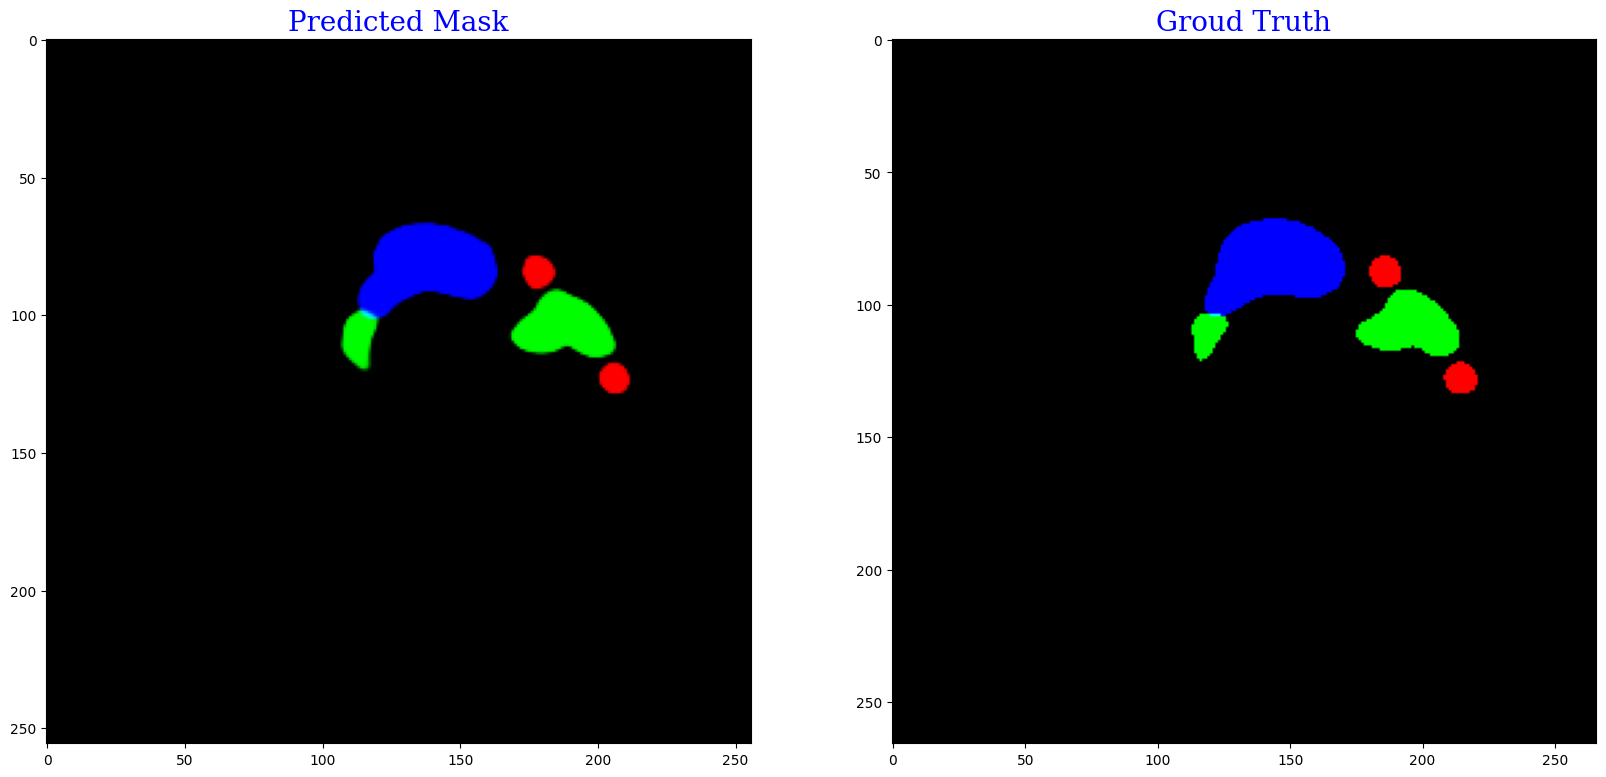

In [77]:
path = r'/content/best_epoch-01.bin'
img_path = r'/content/train/case156/case156_day10/scans/slice_0114_266_266_1.50_1.50.png'
mask_path = r'/content/masks/case156/case156_day10/scans/slice_0114_266_266_1.50_1.50.png'
image = load_image(img_path)
#image = np.transpose(image, (2,0,1))
image = torch.tensor(image)
image = image.permute(2,0,1)
image = np.expand_dims(image, 0)
image = torch.tensor(image)
image = image.cuda()
#Inference
msk = []
msk = torch.zeros((1, 3, 256, 256), dtype=torch.float32)
msk = msk.cuda()
model = load_model(path)
with torch.no_grad():
    out = model(image)
    out = torch.nn.Sigmoid()(out)
    msk += out
    #msk = msk.cuda()

mask = msk.squeeze()
mask = mask.permute(1,2,0)
#mask = mask.cuda()
#mask = np.transpose(mask , (2,0,1))
mask = mask.cpu()

#plot the images
plt.figure(figsize = (20, 10))
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.subplot(1,2,1)
#img = load_image(df.image_paths[i])
#img /= img.max()
plt.title("Predicted Mask", fontdict = font1)
#plt.xlabel("Average Pulse", fontdict = font2)
#plt.ylabel("Calorie Burnage", fontdict = font2)
plt.imshow(mask)
#plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Groud Truth", fontdict = font1)
m = cv2.imread(mask_path, 1)
plt.imshow(m)
#plt.axis('off')

#plt.tight_layout()
plt.show()
